# 循环量子近似优化算法

## 项目介绍

[Obstacles to State Preparation and Variational Optimization from Symmetry Protection](https://arxiv.org/pdf/1910.08980.pdf)

文章提出的Recursive-QAOA方案能极大提高求解成果率，利用MindQuantum复现论文图Fig1类似结果，节点数为20，nc取值不大于8。（文章对一层的QAOA线路直接得到解析结果，这里使用模拟器搭建线路实现）

## 算法原理

### Recursive Quantum Approximate Optimization Algorithm

循环量子近似优化算法(RQAOA, recursive quantum approximate optimization algorithm)

考虑一个根据n顶点图$G_n=(V,E)$定义的类Ising哈密顿量

$$H_n=\sum_{(p,q)\in E}{J_{p,q}Z_pZ_q}$$

其中$J_{p,q}$是$G_n$各边的权重，可以为任意实系数。

RQAOA的目标是近似能量最小值$min_z\langle z\lvert H_n\rvert z \rangle$，其中$z \in \{1,-1\}^n$

### eliminateVariable

RQAOA比QAOA多了个Recursive，在循环中不断根据QAOA的运行结果来消除变量，相当于消除$G_n$的顶点。因此消元(eliminate variable)这步至关重要。

eliminateVariable一般流程：

1. 运行深度p的标准QAOA来找到一个期望最小化$min\langle \Psi^*\lvert H_n\rvert\Psi \rangle$的量子态$\Psi$；

2. 对优化后的量子态$\Psi$按照每条边$e=(i,j)\in E$测量得到$M_e=\langle \Psi^*\lvert Z_iZ_j\rvert\Psi \rangle$；

3. 找到边$f=argmax_{f\in E}\lvert M_f\rvert$，并随机选取顶点$v\in f$,再取出其符号$\sigma=sign(M_f)$；

4. 利用$f,v,\sigma$对$H_n$施加约束$Z_v=\sigma Z_{f\setminus\{v\}}$,即可得到新Ising哈密顿量$H_{n-1}$，也就是消除了图$G_n$的一个顶点生成新图$G_{n-1}$，同时记录下$\xi=(v,f\setminus\{v\},\sigma)$（具体公式参考论文中C.1.）。

### RQAOA

循环地调用eliminateVariable即可将n顶点图$G_n$消元至$n_c$顶点图$G_{n_c}$，其中$n_c\ll n$为指定的阈值。

对于$G_{n_c}$即可用暴力法等方法求解，再根据迭代过程中保存的$\xi$们逆推出$G_n$的解。

## 复现过程

In [1]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from mindquantum.framework import MQAnsatzOnlyLayer
from mindquantum.simulator import Simulator
from mindquantum import MaxCutRQAOAAnsatz
import mindspore.nn as nn
import mindspore as ms

ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

### 1.一般流程

#### 1.1.生成图结构

`generate_graph`生成具有随机连接关系$J_{p,q} = ±1$的随机n节点3正则图

In [2]:
def generate_graph(node_num):
    """
    Generate the graph structure.
    Random weights w∈{+1, -1}.

    Modified from [1].
    [1] https://gitee.com/mindspore/mindquantum/blob/research/paper_recurrence/2022/11_xhliang05/main.ipynb

    Args:
        node_num (int): Number of nodes.
    """
    edges = []
    # 添加环边
    for node in range(node_num-1):
        edges.append(((node, node+1), 2*random.randint(0, 1)-1))
    edges.append(((node_num-1, 0), 2*random.randint(0, 1)-1))
     # 添加内边
    if node_num % 2 == 0: # 如果顶点数为偶数，就采用 3-regular 结构
        for node in range(int(node_num/2)):
            edges.append(((node, int(node+node_num/2)), 2*random.randint(0, 1)-1))
    else:                 # 如果顶点为奇数，只留一个顶点有两条边，其他为三条边
        for node in range(int((node_num-1)/2)):
            edges.append(((node, int(node+(node_num-1)/2)), 2*random.randint(0, 1)-1))
    return edges

生成5节点3正则图

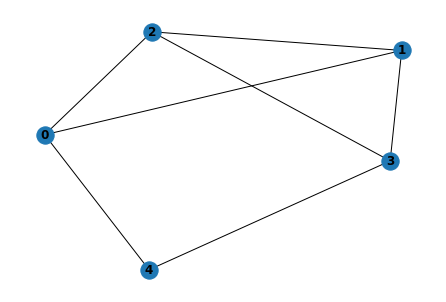

In [3]:
n = 5
g = generate_graph(n)  # 生成图结构

graph = nx.Graph()
for e in g:
    graph.add_edge(e[0][0], e[0][1], J=e[1])
nx.draw(graph, with_labels=True, font_weight='bold')

$n_c$限制为4，即只需消除掉一个节点

In [4]:
nc = 4
mcra = MaxCutRQAOAAnsatz(g, nc=nc)
mcra.ham  # 系统当前哈密顿量

1 [Z0 Z1] +
1 [Z0 Z2] +
-1 [Z0 Z4] +
-1 [Z1 Z2] +
-1 [Z1 Z3] +
1 [Z2 Z3] +
-1 [Z3 Z4] 

#### 1.2.直接调用暴力枚举对图进行求解

In [5]:
ans = mcra.enum(g)
ans

(2, [2, 1])

暴力枚举结果最大切割值为2，切割情况为[2, 1]为一组

通过切割情况计算最大切割值

In [6]:
mcra.get_cut_value(g, ans[1])

2

当前未进行消元，调用`get_result`也可获取暴力枚举结果

In [7]:
mcra.get_result()

(2, [[1, 2], [0, 3, 4]])

#### 1.3.使用RQAOA对图进行消元

In [8]:
circ = mcra.circuit                                        # 当前哈密顿量对应QAOA线路
ham = mcra.hamiltonian                                     # 当前哈密顿量
sim = Simulator('mqvector', circ.n_qubits)                 # 创建模拟器，backend使用‘mqvector’
grad_ops = sim.get_expectation_with_grad(ham, circ)        # 获取计算变分量子线路的期望值和梯度的算子
net = MQAnsatzOnlyLayer(grad_ops)                          # 生成待训练的神经网络
opti = nn.Adam(net.trainable_params(), learning_rate=0.05) # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
train_net = nn.TrainOneStepCell(net, opti)                 # 对神经网络进行一步训练
e = [train_net() for i in range(30)]                       # 训练30次
pr = dict(zip(circ.params_name, net.weight.asnumpy()))     # 获取线路参数
mcra.one_step_rqaoa(pr, 1)                                 # 根据QAOA优化结果消除变量

-- eliminated variable: Z1
-- correlated variable: Z0
-- σ: -1


True

消元正常进行，可以选择显示消元过程，这里利用Z1=-Z0消去Z1

In [9]:
mcra.all_variables     # 查看当前哈密顿量中所有变量

[(0, 'Z'), (2, 'Z'), (3, 'Z'), (4, 'Z')]

可以看到Z1被消除了

In [10]:
mcra.restricted_set    # 查看约束集

[((1, 'Z'), ((0, 'Z'),), -1)]

约束集中保存了Z1换成Z0的相关信息

此时图还剩下4个节点，由于$n<n_c$，无法继续消元

In [11]:
mcra.one_step_rqaoa(pr, 1)

False

#### 1.4.获取结果

通过`get_result`对剩下的4节点图进行暴力枚举法求解，并根据约束集推演出完整解

In [12]:
mcra.get_result()

(2, [[2, 1], [0, 3, 4]])

### 2.论文结果复现

#### 2.1.随机摇10个20节点的问题实例(nc=6和nc=8)来复现论文Fig.1

作如下约定:

* 大体上按照3.1所示流程计算每个问题示例

* 为方便，对于同一个问题实例在计算完nc=8后继续计算至nc=6

* 为防止C出现负数，随机摇到的问题实例需保证最大切割值≥5

#### 2.1.1.运行RQAOA

[运行过程参考](https://gitee.com/mindspore/mindquantum/tree/144aa6e505273d5b23c5026ef1b463da1dc7da2a/paper_recurrence/2023/18_hw58695368)

执行代码生成运行中间文件和结果文件，保存在`./demo/`目录下

#### 2.1.2.结果可视化

[结果数据文件参考](https://gitee.com/mindspore/mindquantum/tree/144aa6e505273d5b23c5026ef1b463da1dc7da2a/paper_recurrence/2023/18_hw58695368)

In [30]:
ar_qaoa = []
ar_rqaoa_nc8 = []
ar_rqaoa_nc6 = []
for i in range(10):
    path_name = f'./demo/demo{i}/demo{i}_n20'
    with open(f'{path_name}_result.pkl', 'rb') as f:
        res = pickle.load(f)
    C_max = res['C_max']
    ar_qaoa.append(res['C_qaoa']/C_max)
    ar_rqaoa_nc8.append(res['C_rqaoa'][8]/C_max)
    ar_rqaoa_nc6.append(res['C_rqaoa'][6]/C_max)

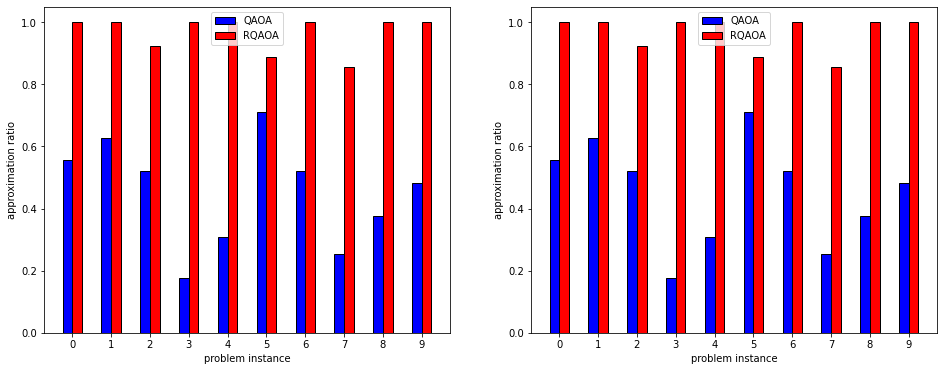

In [41]:
def draw(ax, d_l, d_r):
    x = np.arange(0, len(ar_qaoa)*2, 2)
    width = 0.5
    x1 = x - width / 2
    x2 = x + width / 2
    ax.bar(x1, d_l, width=0.5, label='QAOA', color='blue', edgecolor='k', zorder=2)
    ax.bar(x2, d_r, width=0.5, label='RQAOA', color='red', edgecolor='k', zorder=2)
    ax.set_xlabel('problem instance')
    ax.set_ylabel('approximation ratio')
    ax.set_xticks(x)
    ax.set_xticklabels(x//2)
    ax.legend()

fig = plt.figure(figsize=(16, 6))
draw(fig.add_subplot(1, 2, 1), ar_qaoa, ar_rqaoa_nc8)
draw(fig.add_subplot(1, 2, 2), ar_qaoa, ar_rqaoa_nc6)
plt.show()

FIG. 3: 通过 level-1 QAOA (蓝) 和 RQAOA (红) 分别对 n = 20 (左) 和 n = 20 (右) 的伊森类型哈密顿量 $H_n$ 求解得到的近似率。我们考虑具有随机3-正则图和随机耦合 $J_{p,q} = ±1$ 的1个问题实例。变量消除的截止值选择为 $n_c = 8$(左) 和 $n_c = 6$(右)。近似率算法定义为$\langle z|C_n|z \rangle /C_{max}$，其中$z\in \{-1, 1\}^n$是算法的输出，并且$C_{max} = max_z\langle z|C_n|z \rangle$，其中 $C_n = \frac{1}{2}(\sum J_e-H_n)$。

## 项目总结

### 简要总结

RQAOA(recursive quantum approximate optimization algorithm):

对于Ising-like Hamiltonian

$$H_n=\sum_{p,q\in E}J_{p,q}Z_pZ_q$$

通过QAOA优化到最小期望值后

$$min\langle \Psi^*|H_n|\Psi \rangle$$

$$=min\sum_{p,q\in E}J_{p,q}\langle \Psi^*|Z_pZ_q|\Psi \rangle$$

$$=min\sum_{p,q\in E}J_{p,q}M_{p,q}$$

就可以通过$M_{p,q}$的正负号推定节点p和q的相对关系（±1）

对于一个n节点的问题，用level-p的QAOA线路找节点间的相互关系，并根据该关系来代换掉其中某个相关节点来消减总节点数量，重复此过程直至子问题的节点数满足设定好的阈值$n_c\ll n$。

#### 未来可继续研究的方向

① $n_c$对结果影响

② n对结果的影响/level-p的选取

③ 迭代过程中产生的无边节点剔除并随机赋值±1

④ 允许在单轮迭代中消去多个节点

* M：允许消去大于阈值的所有边的相关节点对中的一个

* P：减少迭代次数

* I：阈值选取及是否会出现矛盾节点链

⑤ 换元过程中尽量减少新边产生